<a href="https://colab.research.google.com/github/JannatLima/Brute_force_pattern/blob/main/Earthquake_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Loading Dataset


In [ ]:
df = pd.read_csv('/content/database.csv')

In [ ]:
# lets check the first five rows of data
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [ ]:
# shape of data
df.shape

(23412, 21)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [ ]:
# Checking for Missing values
df.isnull().sum()

Date                              0
Time                              0
Latitude                          0
Longitude                         0
Type                              0
Depth                             0
Depth Error                   18951
Depth Seismic Stations        16315
Magnitude                         0
Magnitude Type                    3
Magnitude Error               23085
Magnitude Seismic Stations    20848
Azimuthal Gap                 16113
Horizontal Distance           21808
Horizontal Error              22256
Root Mean Square               6060
ID                                0
Source                            0
Location Source                   0
Magnitude Source                  0
Status                            0
dtype: int64

Data Preprocessing

In [ ]:
def preprocess_input(df):
    df = df.copy()
    # dropping ID as its an unrelevant feature.
    df.drop('ID', axis=1,inplace=True)
    # checking for features in which greater than 66%(2/3) of data is missing
    null_columns = df.loc[:, df.isna().sum() > 0.66 * df.shape[0]].columns
    # dropping those columns 
    df.drop(null_columns, axis=1,inplace=True)
    # filling missing values by substituting mean value in rms columns 
    df['Root Mean Square'] = df['Root Mean Square'].fillna(df['Root Mean Square'].mean())
    # filling missing values by substituting mode in Magnitude type columns 
    df['Magnitude Type'] = df['Magnitude Type'].fillna(df['Magnitude Type'].mode()[0])
    df.reset_index(drop=True,inplace=True)
    # converting Date into pandas datetime 
    df['Date'] = pd.to_datetime(df['Date'],utc=True)
    # converting Time into pandas datetime 
    df['Time'] = pd.to_datetime(df['Time'],utc=True)
    # Extracting Year and Month From Date column and converting it into integer
    df['Year'] = df['Date'].apply(lambda x: str(x)[0:4]).astype(np.int)
    df['Month'] = df['Date'].apply(lambda x: str(x)[5:7]).astype(np.int)
    # Extracting Hour From Time column and converting it into integer
    df['Hour'] = df['Time'].apply(lambda x: str(x)[11:13]).astype(np.int)
    
    # dropping Date and Time as we dont need it anymore.
    df.drop(['Date','Time'], axis=1,inplace=True)
    
    # encoding Status to make it numerical.
    df['Status'] = df['Status'].map({'Automatic':0,
                                    'Reviewed':1}).astype('int')
    
    return df

In [ ]:
df = preprocess_input(df)

In [ ]:
# checking missing values again.
df.isnull().sum()

Latitude            0
Longitude           0
Type                0
Depth               0
Magnitude           0
Magnitude Type      0
Root Mean Square    0
Source              0
Location Source     0
Magnitude Source    0
Status              0
Year                0
Month               0
Hour                0
dtype: int64

In [ ]:
# creating list of categorical columns for one hot encoding
categorical_columns = [col for col in df.columns if df.dtypes[col] == 'object']

# creating list of numerical columns to standardized data 
numerical_columns = [col for col in df.columns if ((df.dtypes[col] != 'object') & (col != 'Status'))]

print('Numerical Features are : ',numerical_columns)
print('Categorical Features are : ',categorical_columns)

Numerical Features are :  ['Latitude', 'Longitude', 'Depth', 'Magnitude', 'Root Mean Square', 'Year', 'Month', 'Hour']
Categorical Features are :  ['Type', 'Magnitude Type', 'Source', 'Location Source', 'Magnitude Source']


OneHotEncoding for Categorical Features

In [ ]:
# one hot encoding for categorical features 
def onehot_encoder(df, cols):
    df = df.copy()
    for col in cols:
        dummies = pd.get_dummies(df[col], drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col, axis=1,inplace=True)
    return df

In [ ]:
df = onehot_encoder(df,categorical_columns)

Scaling Numerical Features

In [ ]:
sc = StandardScaler()
df[numerical_columns] = sc.fit_transform(df[numerical_columns])

In [ ]:
df.head()

,Latitude,Longitude,Depth,Magnitude,Root Mean Square,Status,Year,Month,Hour,Explosion,Nuclear Explosion,Rock Burst,MD,MH,ML,MS,MW,MWB,MWC,MWR,MWW,ATLAS,CI,GCMT,ISCGEM,ISCGEMSUP,NC,NN,OFFICIAL,PR,SE,US,UW,AEIC,AG,AGS,AK,ATH,ATLAS,B,...,RSPR,SE,SJA,SLC,SPE,TAP,TEH,THE,THR,TUL,U,UCR,UNM,US,US_WEL,UW,WEL,1009,1020,1023,AK,ATLAS,BRK,CI,GCMT,GUC,HRV,ISCGEM,NC,NIED,NN,OFFICIAL,PAR,PGC,PR,SE,US,US_GCMT,US_PGC,UW
0,0.583377,0.844368,0.495984,0.277668,-2.188775e-14,0,-1.915487,-1.603109,0.225244,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.006109,0.698849,0.075272,-0.195082,-2.188775e-14,0,-1.915487,-1.603109,-0.064982,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.739162,-1.701962,-0.413928,0.750418,-2.188775e-14,0,-1.915487,-1.603109,0.950811,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,-2.017599,-0.503524,-0.454694,-0.195082,-2.188775e-14,0,-1.915487,-1.603109,0.950811,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0.340688,0.691479,-0.454694,-0.195082,-2.188775e-14,0,-1.915487,-1.603109,0.225244,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


Separate dependent and independent variables

In [ ]:
X = df.drop('Status',axis=1)
y = df['Status']

Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

Model Building

In [ ]:
# Create a `Sequential` model and add a Dense layer as the first layer.
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
# Now the model will take as input arrays of shape (None, 104)
# and output arrays of shape (None, 32).
# Note that after the first layer, you don't need to specify
# the size of the input anymore:
model.add(Dense(64, activation='relu'))
# Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('Automatic') 
# and 1 for the other ('Reviewed')
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
#The following is the model summary of the model:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3296      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,473
Trainable params: 5,473
Non-trainable params: 0
_________________________________________________________________


Specifying the optimizer and compile the model

In [ ]:
# Early Stopping
monitor = EarlyStopping(monitor='val_auc', patience=5, 
                        verbose=1, mode='max',restore_best_weights=True)
# Defining Callbacks

filepath = './best_weights.hdf5'
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

reduceLR = ReduceLROnPlateau()
callback_list = [monitor, checkpoint,reduceLR]

# model compile
model.compile(
    optimizer=Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model Fitting

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=25,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/25
403/410 [============================>.] - ETA: 0s - loss: 0.0738 - auc: 0.9932
Epoch 00001: val_auc improved from -inf to 1.00000, saving model to ./best_weights.hdf5
410/410 [==============================] - 3s 4ms/step - loss: 0.0726 - auc: 0.9934 - val_loss: 0.0013 - val_auc: 1.0000 - lr: 0.0010
Epoch 2/25
390/410 [===========================>..] - ETA: 0s - loss: 5.8849e-04 - auc: 1.0000
Epoch 00002: val_auc did not improve from 1.00000
410/410 [==============================] - 1s 3ms/step - loss: 5.7038e-04 - auc: 1.0000 - val_loss: 2.4523e-04 - val_auc: 1.0000 - lr: 0.0010
Epoch 3/25
394/410 [===========================>..] - ETA: 0s - loss: 1.4864e-04 - auc: 1.0000
Epoch 00003: val_auc did not improve from 1.00000
410/410 [==============================] - 1s 3ms/step - loss: 1.4550e-04 - auc: 1.0000 - val_loss: 9.9499e-05 - val_auc: 1.0000 - lr: 0.0010
Epoch 4/25
394/410 [===========================>..] - ETA: 0s - loss: 6.4276e-05 - auc: 1.0000
Epoch 00004: val_a

Result

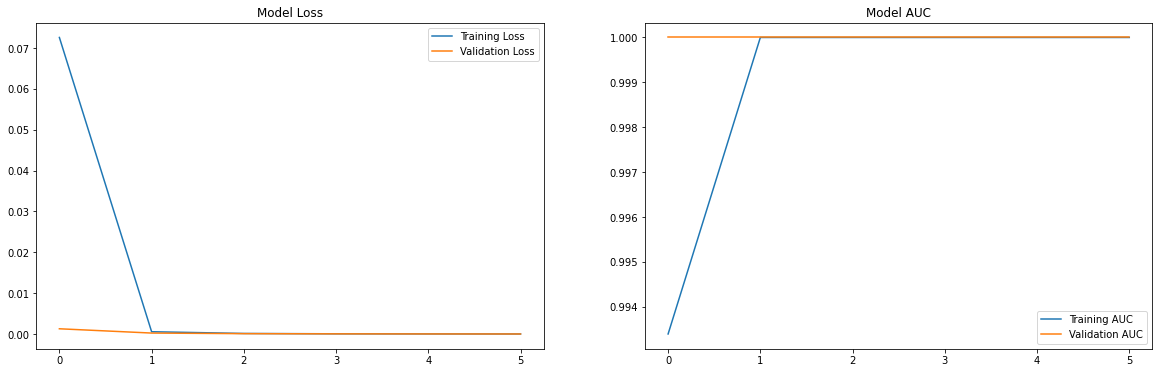

In [ ]:
plt.figure(figsize=(20, 6))

train_loss, val_loss = history.history['loss'], history.history['val_loss']
train_auc, val_auc = history.history['auc'], history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("Model Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label="Training AUC")
plt.plot(history.history['val_auc'], label="Validation AUC")
plt.legend()
plt.title("Model AUC")

plt.show()

Model Evaluation

In [ ]:
model.evaluate(X_test, y_test)

220/220 [==============================] - 0s 2ms/step - loss: 0.0015 - auc: 1.0000


[0.0015097876312211156, 0.9999995827674866]

Model Prediction

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

Result Visualization

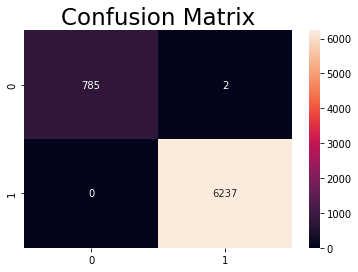

In [ ]:
cf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix,annot=True,fmt="d")
plt.title('Confusion Matrix', fontsize = 23)
plt.show()

In [ ]:
y_test.value_counts()

1    6237
0     787
Name: Status, dtype: int64